**Trích xuất thông tin từ tập dứ liệu, import các thư viện cần thiết**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from pyvi.ViTokenizer import tokenize
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_excel('E:/GitHub/masterthesis/data/ViSentSim-600 - Standard.xlsx', sheet_name='Cosine')

# Loại bỏ các dòng có giá trị NaN nếu có
df = df.dropna(subset=['Câu 1', 'Câu 2'])

all_sentences = list(df['Câu 1']) + list(df['Câu 2'])

ground_truth = list(df['Mức tương tự'])

c:\Users\minh.nguyenquang1\AppData\Local\anaconda3\envs\masterthesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Thiết lập cách tính toán tại mỗi layer**

In [2]:
def jaccard_similarity(sent1, sent2):
    #tách từ sinh viên => sinh_viên
    #trọng số ?
    # Tokenize the sentences into words
    words1 = set(sent1.lower().split())
    words2 = set(sent2.lower().split())

    # Calculate the intersection and union of the word sets
    intersection = words1.intersection(words2)
    union = words1.union(words2)

    # Jaccard similarity is the size of the intersection divided by the size of the union
    jaccard_score = len(intersection) / len(union) if len(union) > 0 else 0

    return jaccard_score

def LCSubstr(s1, s2):
    ws1 =  s1.split()
    ws2 =  s2.split()
    l1= len(ws1)
    l2= len(ws2)
    m= max(l1, l2)+1
    F = np.zeros( (m, m) )
    for i in range(len(ws1)):
        for j in range(len(ws2)):
            if ws1[i]==ws2[j]:
                F[i+1,j+1] = F[i,j] +1
            else:
                F[i+1,j+1]  = max(F[i,j+1] , F[i+1,j] )
    return F[l1, l2] / max(l1, l2)

import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def word_movers_distance(embedding1, embedding2):
    # Calculate distance matrix
    distance_matrix = cdist(embedding1, embedding2, metric='euclidean')
    
    # Normalize the embeddings to create probability distributions
    p = np.ones(len(embedding1)) / len(embedding1)
    q = np.ones(len(embedding2)) / len(embedding2)
    
    # Solve the transportation problem
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # Calculate WMD
    wmd = np.sum(distance_matrix[row_ind, col_ind])
    return wmd




**Tính toán phân bố của bộ dữ liệu với lớp Cosine Sim, Jaccard, LCS**

In [4]:
model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
embeddings = model.encode(all_sentences)

No sentence-transformers model found with name VoVanPhuc/sup-SimCSE-VietNamese-phobert-base. Creating a new one with mean pooling.


In [8]:


def get_distribution_cosine_similarity():

  # Lấy các similarity scores
  # n = len(df)
  n = len(all_sentences) // 2
  scores = []
  print("DF length: "  , n) 
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(cosine_similarity([embeddings[i]], [embeddings[i+n]]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(cosine_similarity([embeddings[i]], [embeddings[j]]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(cosine_similarity([embeddings[i]], [embeddings[j]]))
  return scores

In [5]:
def get_distribution_wmd(embeddings, all_sentences):
    n = len(all_sentences) // 2
    distances = []
    print("DF length: ", n)
    
    # WMD between sentence pairs (Sentence 1 and Sentence 2)
    for i in range(n):
        wmd = word_movers_distance(
            embedding1=embeddings[i].reshape(1, -1),
            embedding2=embeddings[i+n].reshape(1, -1)
        )
        distances.append(wmd)
    
    # WMD within Sentence 1 group
    for i in range(n):
        for j in range(i+1, n):
            wmd = word_movers_distance(
                embedding1=embeddings[i].reshape(1, -1),
                embedding2=embeddings[j].reshape(1, -1)
            )
            distances.append(wmd)
    
    # WMD within Sentence 2 group
    for i in range(n, 2*n):
        for j in range(i+1, 2*n):
            wmd = word_movers_distance(
                embedding1=embeddings[i].reshape(1, -1),
                embedding2=embeddings[j].reshape(1, -1)
            )
            distances.append(wmd)
            
    return distances

In [9]:
def get_distribution_jaccard_similarity():
  # Lấy các similarity scores
  # n = len(df)
  n = len(all_sentences) // 2
  scores = []
  print("DF length: "  , n)
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(jaccard_similarity(all_sentences[i], all_sentences[i+n]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(jaccard_similarity(all_sentences[i], all_sentences[j]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(jaccard_similarity(all_sentences[i], all_sentences[j]))
  return scores

In [10]:
def get_distribution_lcs_similarity():
  # n = len(df)
  n = len(all_sentences) // 2
  # Lấy các similarity scores
  scores = []
  print("DF length: "  , n)
  # Similarity giữa Câu 1 và Câu 2
  for i in range(n):
      scores.append(LCSubstr(all_sentences[i], all_sentences[i+n]))

  # Similarity trong nội bộ Câu 1
  for i in range(n):
      for j in range(i+1, n):
          scores.append(LCSubstr(all_sentences[i], all_sentences[j]))

  # Similarity trong nội bộ Câu 2
  for i in range(n, 2*n):
      for j in range(i+1, 2*n):
          scores.append(LCSubstr(all_sentences[i], all_sentences[j]))
  return scores

In [11]:
cosine_sim_distribution = get_distribution_cosine_similarity()
jaccard_distribution = get_distribution_jaccard_similarity()
lcs_distribution = get_distribution_lcs_similarity()
wmd_distribution = get_distribution_wmd(embeddings, all_sentences)

DF length:  600
DF length:  600
DF length:  600
DF length:  600


In [15]:
#Phân bố chung của hai lớp jaccard và LCS
jac_lcs_distribution = []
for i in range(0, len(jaccard_distribution)):
  jac_lcs_distribution.append( (jaccard_distribution[i] + lcs_distribution[i])/2)

In [12]:
##Vẽ dis char
# Chuyển scores thành numpy array 1 chiều
import numpy as np
def distribution_chart():

  scores = np.array(cosine_sim_distribution).flatten()

  scores2 = np.array(jaccard_distribution).flatten()

  scores3 = np.array(lcs_distribution).flatten()

  scores4 = np.array(wmd_distribution).flatten()
  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores, bins=50, kde=True)
  plt.title('Phân bố Cosine Similarity Scores')
  plt.xlabel('Cos Similarity Score')
  plt.ylabel('Số lượng')
  plt.show()


  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores2, bins=50, kde=True)
  plt.title('Phân bố Jaccard Similarity Scores')
  plt.xlabel('Jaccard Score')
  plt.ylabel('Số lượng')
  plt.show()

  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores3, bins=50, kde=True)
  plt.title('Phân bố LCS Similarity Scores')
  plt.xlabel('LCS Score')
  plt.ylabel('Số lượng')
  plt.show()

  # Vẽ biểu đồ phân bố
  plt.figure(figsize=(12, 8))
  sns.histplot(scores4, bins=50, kde=True)
  plt.title('Phân bố WMD Similarity Scores')
  plt.xlabel('WMD Score')
  plt.ylabel('Số lượng')
  plt.show()
  # Vẽ biểu đồ phân bố
  # score4_mean = []
  # for i in range(0, len(jaccard_distribution)):
  #   score4_mean.append( (jaccard_distribution[i] + lcs_distribution[i])/2)

  # plt.figure(figsize=(12, 8))
  # sns.histplot(score4_mean, bins=50, kde=True)
  # plt.title('Phân bố LCS+Jacard Similarity Scores')
  # plt.xlabel('LCS+Jaccard Score')
  # plt.ylabel('Số lượng')
  # plt.show()

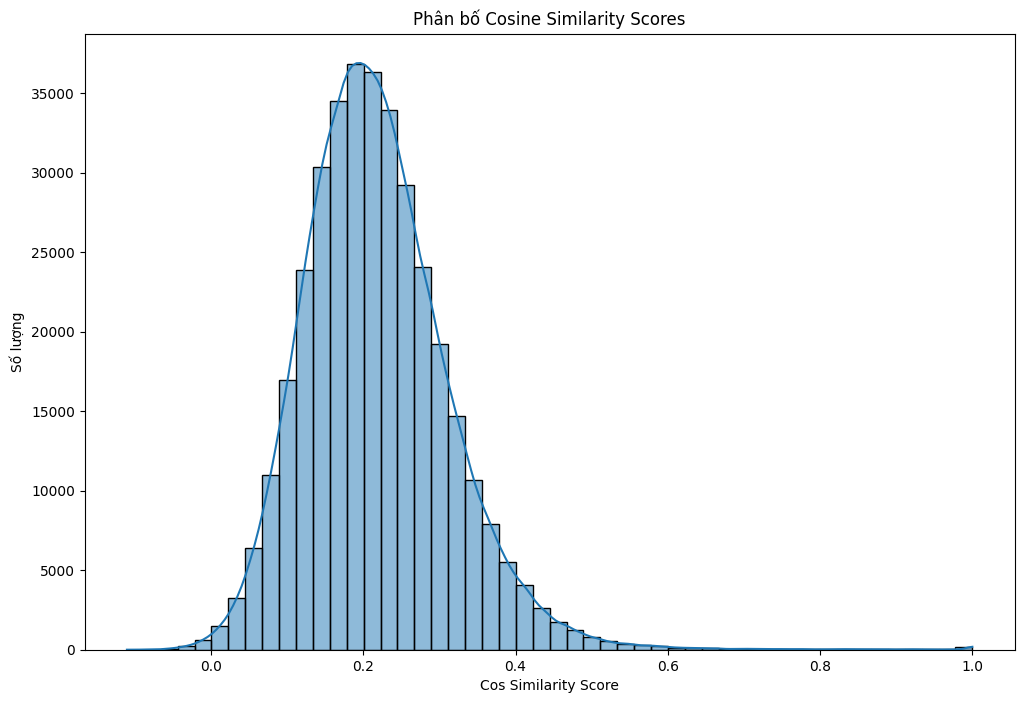

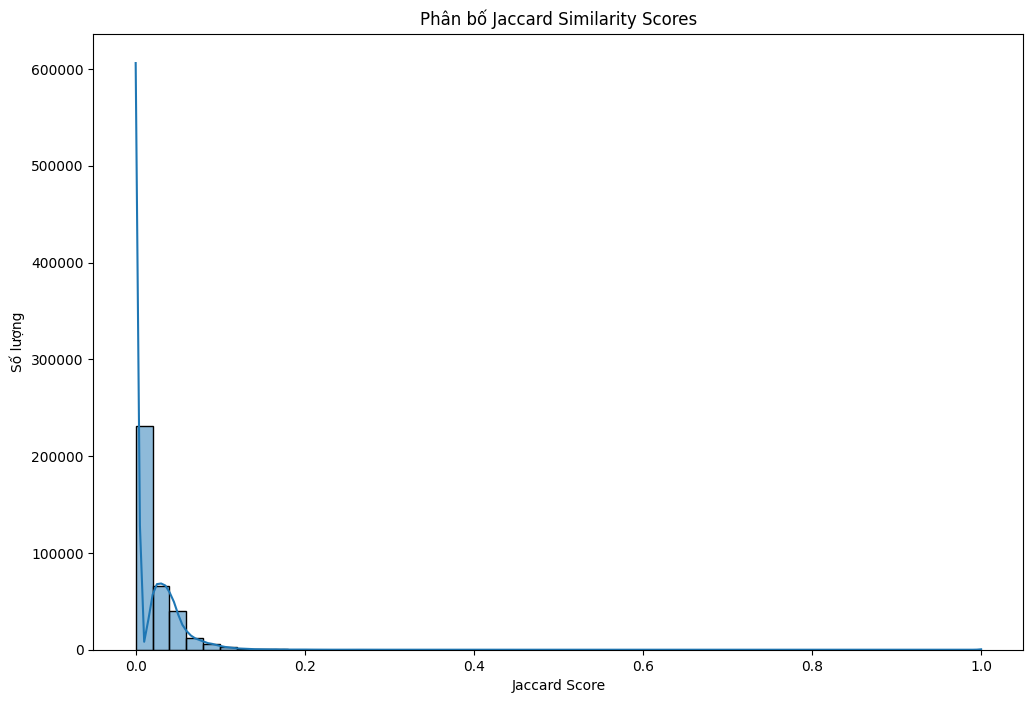

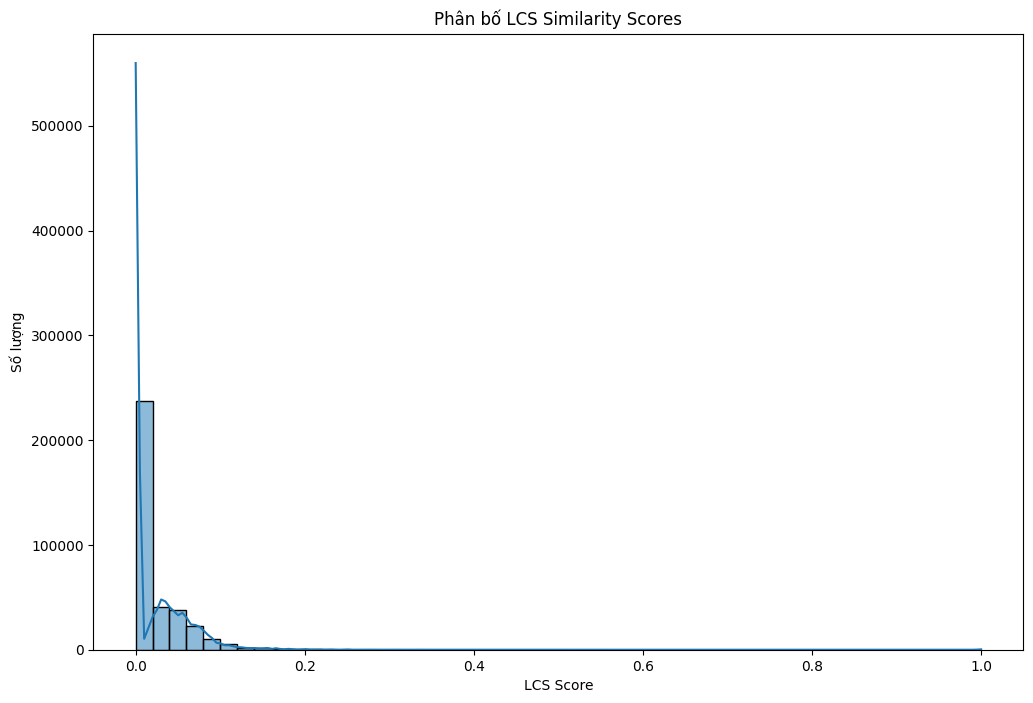

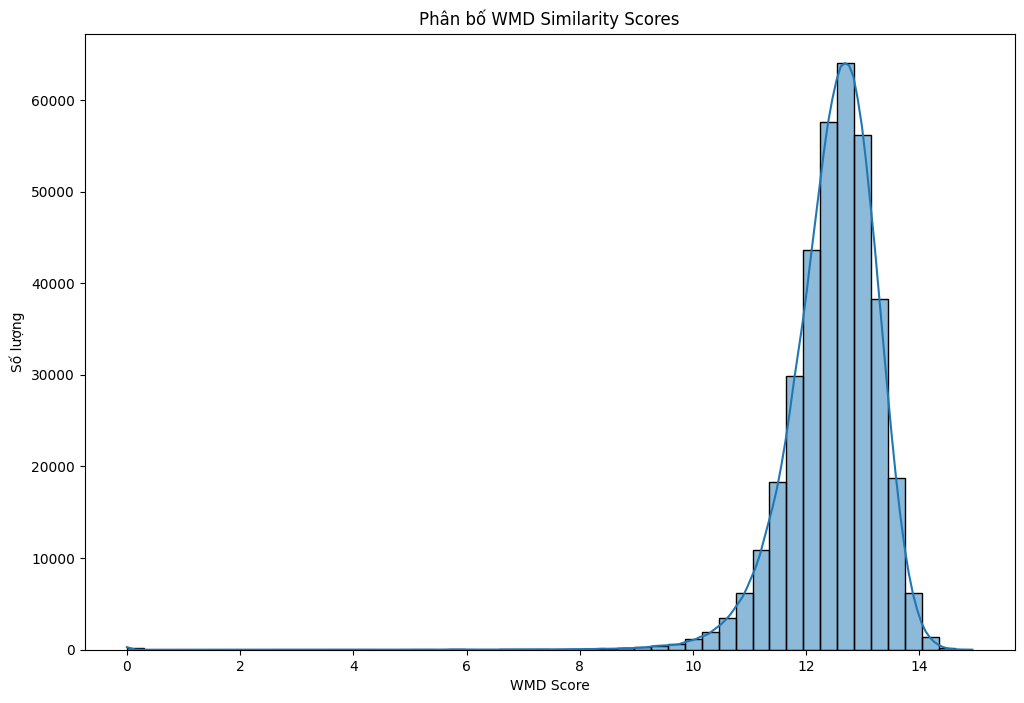

In [13]:
distribution_chart()

In [90]:
import numpy as np
from scipy.spatial.distance import jensenshannon

dist1_flat = []
for arr in cosine_sim_distribution:
  # print(arr[0][0])
  dist1_flat.append(arr[0][0])

def safe_jensenshannon_for_lists(dist1, dist2, epsilon=1e-10):
    # Convert to numpy arrays and handle potential issues
    dist1_array = np.array(dist1, dtype=float)
    dist2_array = np.array(dist2, dtype=float)


    # Add small epsilon to prevent zero probabilities
    dist1_safe = dist1_array + epsilon
    dist2_safe = dist2_array + epsilon

    # Normalize distributions
    dist1_norm = dist1_safe / np.sum(dist1_safe)
    dist2_norm = dist2_safe / np.sum(dist2_safe)

    # Ensure non-negative and sum to 1
    dist1_norm = np.maximum(dist1_norm, 0)
    dist2_norm = np.maximum(dist2_norm, 0)
    dist1_norm /= np.sum(dist1_norm)
    dist2_norm /= np.sum(dist2_norm)

    # Calculate Jensen-Shannon divergence
    try:
        js_distance = jensenshannon(dist1_norm, dist2_norm)
        return js_distance
    except Exception as e:
        print("Calculation error:", e)
        return None

# Usage
result = safe_jensenshannon_for_lists(dist1_flat, jaccard_distribution)
print("Jensen-Shannon Distance:", result)

result2 = safe_jensenshannon_for_lists(dist1_flat, lcs_distribution)
print("Jensen-Shannon Distance:", result2)

result3 = safe_jensenshannon_for_lists(lcs_distribution, jaccard_distribution)
print("Jensen-Shannon Distance:", result3)

print((result + result2 + result3)/3)
print((result + result2 )/2)

Jensen-Shannon Distance: 0.5239362673330513
Jensen-Shannon Distance: 0.5448664262894156
Jensen-Shannon Distance: 0.18772935726466722
0.418844016962378
0.5344013468112334


In [8]:
#Build the graph

#Cos-sim Graph
cos_similarity_graph = []
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):  # Avoid redundant pairs (i.e., only upper triangle of the matrix)
      if cosine_similarity([embeddings[i]], [embeddings[j]]) >= 0.2:
        cos_similarity_graph.append((i, j, cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]))


In [9]:
#Jaccard Graph
jaccard_graph = []
for i in range(len(all_sentences)):
    for j in range(i + 1, len(all_sentences)):
      if jaccard_similarity(all_sentences[i], all_sentences[j]) >= 0.02:
        jaccard_graph.append((i, j, jaccard_similarity(all_sentences[i], all_sentences[j])))

In [10]:
#LCS Graph
lcs_graph = []
for i in range(len(all_sentences)):
    for j in range(i + 1, len(all_sentences)):
      if LCSubstr(all_sentences[i], all_sentences[j]) >= 0.02:
        lcs_graph.append((i, j, LCSubstr(all_sentences[i], all_sentences[j])))

In [19]:
#Combine LCS graph and Jaccard Graph:
lcs_jaccard_graph =  []
for i in range(0, len(lcs_graph)):
# print(lcs_graph[0])
# print(lcs_graph[i](lcs_graph[0][0]))
  lcs_jaccard_graph.append( ((lcs_graph[i][0], lcs_graph[i][1], (jaccard_graph[i][2] + lcs_graph[i][2])/2)))

In [ ]:
print(lcs_jaccard_graph[1])
print(lcs_graph[1])
print(jaccard_graph[1])

(1, 91, 0.157679033649698)
(1, 91, 0.18421052631578946)
(1, 91, 0.13114754098360656)


In [29]:

import json
def remove_common_keys(dict1, dict2):
    # Find common keys
    common_keys = set(dict1.keys()) & set(dict2.keys())
    
    # Remove common keys from both dictionaries
    for key in common_keys:
        del dict1[key]
        del dict2[key]
    
    return dict1, dict2

def find_adjacent(node_A, node_B, cosine_similarities):
# Identify adjacent nodes for A and B
  adjacent_to_A = {}
  for a, b, score in cosine_similarities:
        if a == node_A:
            adjacent_to_A[b] = score
        elif b == node_A:
            adjacent_to_A[a] = score
  try:
    adjacent_to_A.pop(node_B)
  except:
    pass
  adjacent_to_B = {}
  for a, b, score in cosine_similarities:
      if b == node_B:
          adjacent_to_B[a] = score
      elif a == node_B:
          adjacent_to_B[b] = score
  try:
    adjacent_to_B.pop(node_A)
  except:
    pass
  
  # print(adjacent_to_A)
  # print(adjacent_to_B)
  #Loại bỏ các node bị trùng
  adjacent_to_A, adjacent_to_B = remove_common_keys(adjacent_to_A, adjacent_to_B)
  # print(adjacent_to_A)
  # print(adjacent_to_B)
  # print("adjacent_to_A: ", dict(sorted(adjacent_to_A.items(), key=lambda item: item[1], reverse=True)))
  # print("adjacent_to_B: ", dict(sorted(adjacent_to_B.items(), key=lambda item: item[1], reverse=True)))
  # return adjacent_to_A, adjacent_to_B
  return list(dict(sorted(adjacent_to_A.items(), key=lambda item: item[1], reverse=True)))[:10], list(dict(sorted(adjacent_to_B.items(), key=lambda item: item[1], reverse=True)))[:10]

def find_sim_score(nodeA, nodeB, edges_list):
    # Find similarity score between two nodes from edges list
    for a, b, score in edges_list:
        if (a == nodeA and b == nodeB) or (a == nodeB and b == nodeA):
            return score
    return 0

#Cần sửa lại để đsung logic
def calculate_equation16(nodeA, nodeB, adj_A, adj_B, simScore):
  sum_weight = 0

  # Find common adjacent nodes between nodeA and nodeB
  # common_adj = set(adj_A).intersection(set(adj_B))
  # print("Common_node: ", common_adj)
  # for common_node in common_adj:
  #   adj_A.remove(common_node)
  #   adj_B.remove(common_node)
  # print("Sau remove: ", adj_A)
  # print("Sau remove: ", adj_B)

  for node_A_adj in adj_A:
      for node_B_adj in adj_B:
      # Calculate weight(C,D) = cos_sim(A,C) × cos_sim(B,D)
        weight = (find_sim_score(nodeA, node_A_adj, simScore) *
                find_sim_score(nodeB, node_B_adj, simScore))
        # print("Node_pair: ", node_A_adj, node_A_adj)
        # print("Weight: ", weight)
        sum_weight += weight

  return sum_weight

def calculate_equation17(nodeA, nodeB, adj_A, adj_B, simScore):
    sum_weighted = 0

    # Find common adjacent nodes between nodeA and nodeB
    # common_adj = set(adj_A).intersection(set(adj_B))
    # print("Common_node: ", common_adj)
    # for common_node in common_adj:
    #   adj_A.remove(common_node)
    #   adj_B.remove(common_node)
    # print("Sau remove: ", adj_A)
    # print("Sau remove: ", adj_B)    
    for node_A_adj in adj_A:
      for node_B_adj in adj_B:  
            # Get cosine similarity between the common adjacent nodes
            sim = find_sim_score(node_A_adj, node_B_adj, simScore)
            weight = (find_sim_score(nodeA, node_A_adj, simScore) * find_sim_score(nodeB, node_B_adj, simScore))
            # print("Node_pair: ", weight)
            # Calculate final weighted value
            weighted = sim * weight
            sum_weighted += weighted
    return sum_weighted


def calculate_equation15(nodeA, nodeB, adj_A, adj_B, simScore):
    # Get cos_sim(A,B) - the direct similarity between A and B
    cos_sim_AB = find_sim_score(nodeA, nodeB, simScore)

    # Calculate sum_wtd(A,B) using equation 17
    sum_wtd = calculate_equation17(nodeA, nodeB, adj_A, adj_B, simScore)
    # print("Weighted: ", sum_wtd)
    # Calculate sum_w_adj(A,B) using equation 16
    sum_w_adj = calculate_equation16(nodeA, nodeB, adj_A, adj_B, simScore)
    # print("Weight: ", sum_w_adj)
    # Final formula: (cos_sim(A,B) + sum_wtd(A,B)) / (1 + sum_w_adj(A,B))
    similarity = (cos_sim_AB + sum_wtd) / (1 + sum_w_adj)

    return similarity

def local_similarity(nodeA, nodeB, sim_list):

  adjacent_to_A, adjacent_to_B = find_adjacent(nodeA,nodeB, sim_list)
  # adjacent_to_1_jackcard, adjacent_to_2_jackcard = find_adjacent(nodeA,nodeB, jaccard_similarities)

  final_similarity = calculate_equation15(nodeA, nodeB, adjacent_to_A, adjacent_to_B, sim_list)
  # final_similarity2 = calculate_equation15(nodeA, nodeB, adjacent_to_1, adjacent_to_2, jaccard_similarities)

  # print(f"Final similarity score cosine between nodes {nodeA} and {nodeB}: {final_similarity}")
  # print(f"Final similarity score jaccard between nodes {nodeA} and {nodeB}: {final_similarity2}")
  return final_similarity

def overall_sentence_similarity(localsim:list, jsd_sum, jsd_main):
  sum = 0
  mul= 1
  for local in localsim[1:]:
    print(local)
    sum = sum + local
    mul = mul * local

  result =  jsd_sum *  (localsim[0]+ (mul/(jsd_main*sum)))
  # 1.25653205089 * 
  # for i in localsim:
  #   sum = sum + i
  #   mul = mul * i
  # # print("SUM: ", sum)
  # # print("MUL: ", mul)
  # result = mul(jsd*sum)
  # # print(result)
  # # result = (jsd*sum)
  # return  result if result < 1.0 else localsim[0]
  return result

def get_local_sim_from_jaccard_layer():
  data_jaccard = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,600):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 600   
    data_jaccard[sentence_pair_index] = local_similarity(nodeA, nodeB, jaccard_graph) 
  with open('./jaccard_layer_local_sim.json', 'w') as file:
    json.dump(data_jaccard, file)

def get_local_sim_from_lcs_layer():
  data_lcs = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,600):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 600
    data_lcs[sentence_pair_index] = local_similarity(nodeA, nodeB, lcs_graph) 
  with open('./lcs_layer_local_sim.json', 'w') as file:
    json.dump(data_lcs, file)

def get_local_sim_from_cos_layer():
  data_cos = {}
  # calculated_sim_from_all_graph = []
  for sentence_pair_index in range(0,600):
    # print(sentence_pair_index)
    nodeA = sentence_pair_index
    nodeB = nodeA + 600
    # print(local_similarity(nodeA, nodeB, cos_similarity_graph) ) # The JSON you received from a function
    data_cos[sentence_pair_index ] = float(local_similarity(nodeA, nodeB, cos_similarity_graph) ) # The JSON you received from a function
  with open('./cos_layer_local_sim.json', 'w') as file:
    json.dump(data_cos, file)

# get_local_sim_from_lcs_layer()
get_local_sim_from_cos_layer()

In [35]:
def get_overall_sim_from_all_layers():
    calculated_sim_from_all_graph = []
    with open('./cos_layer_local_sim.json', 'r') as file:
        cos_sim_local = json.load(file)
        print(cos_sim_local)
    with open('./jaccard_layer_local_sim.json', 'r') as file:
        jaccard_sim_local = json.load(file)
        print(jaccard_sim_local)
    with open('./lcs_layer_local_sim.json', 'r') as file:
        lcs_sim_local = json.load(file)
        print(lcs_sim_local)

    jsd_main = 0.5344013468112334
    jsd_sum = 1.25653205089
    for sentence_pair_index in range(0,600):
        calculated_sim_from_all_graph.append(overall_sentence_similarity([find_sim_score(sentence_pair_index, sentence_pair_index +600, cos_similarity_graph), cos_sim_local[str(sentence_pair_index)], jaccard_sim_local[str(sentence_pair_index)], lcs_sim_local[str(sentence_pair_index)]],jsd_sum, jsd_main))
    return calculated_sim_from_all_graph

overall_sim_graph = get_overall_sim_from_all_layers()

{'0': 0.12525145709514618, '1': 0.24447689950466156, '2': 0.1633751392364502, '3': 0.16625064611434937, '4': 0.12154775857925415, '5': 0.19691015779972076, '6': 0.09234943985939026, '7': 0.09529827535152435, '8': 0.19668875634670258, '9': 0.1425250768661499, '10': 0.15207408368587494, '11': 0.033738862723112106, '12': 0.23918545246124268, '13': 0.17229633033275604, '14': 0.17916640639305115, '15': 0.16655756533145905, '16': 0.13363878428936005, '17': 0.1872154027223587, '18': 0.10472487658262253, '19': 0.20699618756771088, '20': 0.1458471566438675, '21': 0.09556122124195099, '22': 0.23071475327014923, '23': 0.13157278299331665, '24': 0.18323659896850586, '25': 0.0959382951259613, '26': 0.06501193344593048, '27': 0.39493098855018616, '28': 0.11730384081602097, '29': 0.19000473618507385, '30': 0.16630737483501434, '31': 0.09928978979587555, '32': 0.09430491179227829, '33': 0.17872148752212524, '34': 0.12436214834451675, '35': 0.1635330617427826, '36': 0.13219232857227325, '37': 0.1290296

In [76]:
#Pearson score với baseline model embedding
from scipy import stats
calculated_sim_baseline = []
for i in range(0, 600):
 calculated_sim_baseline.append(cosine_similarity([embeddings[i]], [embeddings[i+600]])[0][0])
pearson_correlation, p_value = stats.pearsonr(calculated_sim_baseline, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.8069059154076528
P-value: 7.496287218845672e-139


In [36]:
from scipy import stats
# print(ground_truth)
# print(calculated_sim_from_all_graph)
# Alternatively
pearson_correlation, p_value = stats.pearsonr(overall_sim_graph, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.811820223924519
P-value: 7.538786934650217e-142


In [ ]:
list_test = []
for i in range(0,600):
    print("-------------------")
    print("Sentence pair: ", i)
    # print(calculated_sim_from_all_graph[i])
    print(ground_truth[i])
    # list_test.append(float(number))
#     print(number)
#     print("-------------------")
#     print(calculated_sim_from_all_graph[number])
#     print(arr2[number])
# print(list_test)




    # print("----------------------------------------------")
    # print(all_sentences[nodeA])
    # print(all_sentences[nodeB])
    # import json
    # print("Adjacent nodeA, nodeB (Cos Layer): ", find_adjacent(nodeA, nodeB, cos_similarity_graph))
    # print("Basic cos sim score: ", find_sim_score(nodeA, nodeB, cos_similarity_graph))
    # print("Mnetsim local layer score (Cos layer): ", local_similarity(nodeA, nodeB, cos_similarity_graph))
    # # local_similarity(nodeA, nodeB,lcs_jaccard_graph)
    # print("----------------------------------------------")
    # print("Adjacent nodeA, nodeB (Jac Layer): ", find_adjacent(nodeA, nodeB, jaccard_graph))
    # print("Basic Jac Layer sim score: ", find_sim_score(nodeA, nodeB, jaccard_graph))
    # print("Mnetsim local layer score (Jac Layer layer): ", local_similarity(nodeA, nodeB, jaccard_graph))
    # print("----------------------------------------------")
    # print("Adjacent nodeA, nodeB (LCS Layer): ", find_adjacent(nodeA, nodeB, lcs_graph))
    # print("Basic LCS Layer sim score: ", find_sim_score(nodeA, nodeB, lcs_graph))
    # print("Mnetsim local layer score (LCS Layer layer): ", local_similarity(nodeA, nodeB, lcs_graph))

    # print("----------------------------------------------")
    # localsim = [find_sim_score(nodeA, nodeB, cos_similarity_graph), local_similarity(nodeA, nodeB, jaccard_graph), local_similarity(nodeA, nodeB, lcs_graph)]
    # localsim = [find_sim_score(nodeA, nodeB, cos_similarity_graph), local_similarity(nodeA, nodeB, cos_similarity_graph), local_similarity(nodeA, nodeB, jaccard_graph), local_similarity(nodeA, nodeB, lcs_graph)]
    # print(localsim)

    # localsim = [local_similarity(nodeA, nodeB, cos_similarity_graph)]

    # print(localsim)
    # print("SIM SCORE: ", find_sim_score(26, 601, lcs_graph))

    # jsd = 0.2510184830183568
    # jsd = 0.5271893468924526
    # jsd_main = 0.4188440171202534




# jsd_main = 0.5344013468112334
  # jsd_jac_lcs = 0.25
  # jsd_main = 0.6
# calculated_sim_from_all_graph.append(overall_sentence_similarity(localsim))
  # calculated_sim_from_all_graph.append(cosine_similarity([embeddings[sentence_pair_index]], [embeddings[sentence_pair_index+600]])[0][0])

  # print("Overall: ", overall_sentence_similarity(localsim))
# 
# get_local_sim_from_jaccard_layer()

-------------------
Sentence pair:  0
0.7026763985947115
0.758893
-------------------
Sentence pair:  1
0.98563164
0.995781
-------------------
Sentence pair:  2
0.76451886
0.9378213
-------------------
Sentence pair:  3
0.49219803466658946
0.7884649
-------------------
Sentence pair:  4
0.70515954
0.9018766
-------------------
Sentence pair:  5
0.81443685
0.96544576
-------------------
Sentence pair:  6
0.5020003027441693
0.6719507
-------------------
Sentence pair:  7
0.4933909265950719
0.82820404
-------------------
Sentence pair:  8
0.8174082
0.95253265
-------------------
Sentence pair:  9
0.8533034389247557
0.84586465
-------------------
Sentence pair:  10
0.812892
0.871588
-------------------
Sentence pair:  11
0.5948213944386712
0.8567755
-------------------
Sentence pair:  12
0.98110807
0.9750956
-------------------
Sentence pair:  13
0.7870351
0.92559123
-------------------
Sentence pair:  14
0.87517536
0.95633614
-------------------
Sentence pair:  15
0.5969285662933984
0.83

In [106]:
pearson_correlation, p_value = stats.pearsonr(list_test, ground_truth)
print(f"Pearson Correlation: {pearson_correlation}")

Pearson Correlation: 0.7590090706611388


In [17]:
def find_most_frequent_distribution(distribution):
    scores = np.array(distribution).flatten()

    # Create histogram
    hist, bin_edges = np.histogram(scores, bins=50)

    # Find the index of the bin with the highest count
    max_count_index = np.argmax(hist)

    # Get the center of the bin with the highest count
    most_frequent_value = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2

    print(f"Bin with highest distribution: {most_frequent_value}")
    print(f"Number of items in this bin: {hist[max_count_index]}")

find_most_frequent_distribution(cosine_sim_distribution)
find_most_frequent_distribution(jaccard_distribution)
find_most_frequent_distribution(lcs_distribution)

Bin with highest distribution: 0.1894773691892624
Number of items in this bin: 36837
Bin with highest distribution: 0.01
Number of items in this bin: 231000
Bin with highest distribution: 0.01
Number of items in this bin: 237660
